<html>
   <head>
      <title>Customer Life Time Value</title>
   </head>
   <body>
      <h1><font size="6">Part 4: Customer Lifetime Value</font></h1>
      <ul style="list-style-type:none;line-height: 2;">
         <li><font size="3"><a href='#1'>1. Lifetime Value Calculation by hand</a></font></li>
             <ul style="margin-left: 1em; padding-left: 1em;list-style-type:none">
             <li><font size="3"><a href='#1.1'>1.1 Calculate rates</a></font></li>
             <li><font size="3"><a href='#1.2'>1.2 Customer Lifetime Value</a></font></li>
          </ul>
         <li><font size="3"><a href='#2'>2. Lifetime Value Prediction</a></font></li>
             <ul style="margin-left: 1em; padding-left: 1em;list-style-type:none">
             <li><font size="3"><a href='#2.1'>2.1 Data Preparation</a></font></li>
             <li><font size="3"><a href='#2.2'>2.2 Model 1</a></font></li>
             <li><font size="3"><a href='#2.3'>2.3 Model 2 (CSV)</a></font></li> 
          </ul>
      </ul>
   </body>
</html>

## Importing libraries

In [1]:
# Importing the necessary libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import datetime
from operator import itemgetter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score
from sklearn.mixture import GaussianMixture

## Setting options

In [2]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 400)

## Loading Dataframes

In [3]:
df = pd.read_pickle("./Data/dataframefull.pickle")
df_userscr = pd.read_pickle("./Data/users_with_score.pickle")

<a id='1'></a>

# 1. Lifetime Value Calculation by hand

<a id='1.1'></a>

### 1.1 Calculate rates (assuming constants)

In [4]:
#overall purchase frequency
purchase_frequency = sum(df_userscr['total_purchases']) / df_userscr.shape[0]

In [5]:
#overall repetition rate
repeat_rate = df_userscr[df_userscr.total_purchases > 1].shape[0] / df_userscr.shape[0]

In [6]:
#churn rate
churn_rate = 1 - repeat_rate

In [7]:
purchase_frequency,repeat_rate,churn_rate

(1.3411856727329963, 0.17860578814905473, 0.8213942118509453)

<a id='1.2'></a>

### 1.2 Customer Lifetime Value

In [8]:
df_constant_ltv = df_userscr.copy()

In [9]:
#customer value
df_constant_ltv['c_value'] = round((df_constant_ltv['avg_shop_cart'] * purchase_frequency) / churn_rate, 2)

In [10]:
#profit variable, here arbitrarily assume that 6% of sales is profit
df_constant_ltv['profit_margin'] = df_constant_ltv['revenue'] * 0.06

In [11]:
#lifetime value
df_constant_ltv['clv'] = (df_constant_ltv['c_value'] * df_constant_ltv['profit_margin']).round(2)

In [12]:
df_constant_ltv.head()

,user_id,revenue,women_article,men_article,kids_article,homeandliving_article,avg_shop_cart,total_purchases,avg_cart_itemcount,monday,times_bought_monday,tuesday,times_bought_tuesday,wednesday,times_bought_wednesday,thursday,times_bought_thursday,friday,times_bought_friday,saturday,times_bought_saturday,sunday,times_bought_sunday,user_type,country,region,city,device_category,device_browser,device_os,country_slim,cluster,recency,frequency,score,value_segment,c_value,profit_margin,clv
0,1,147.01,6,1,0,0,73.505,2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,first,Germany,Lower Saxony,Varel,desktop,Firefox,Windows,Germany,0,216,2,1,low,120.02,8.8206,1058.65
1,2,208.34,8,0,0,0,208.340,1,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,first,Germany,Mecklenburg-Vorpommern,Stralsund,desktop,Internet Explorer,Windows,Germany,1,454,1,1,low,340.18,12.5004,4252.39
2,3,84.11,0,1,0,0,84.110,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Lower Saxony,Buchholz in der Nordheide,tablet,Safari,iOS,Germany,0,339,1,0,low,137.34,5.0466,693.10
3,4,62.32,1,4,0,0,62.320,1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Berlin,Berlin,desktop,Chrome,Windows,Germany,0,42,1,2,low,101.76,3.7392,380.50
4,5,89.89,0,0,4,0,44.945,2,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Schleswig-Holstein,Neumunster,tablet,Safari,iOS,Germany,0,185,2,1,low,73.39,5.3934,395.82


<a id='2'></a>

# 2. Lifetime Value Prediction

<a id='2.1'></a>

### 2.1 Data Preparation

In [13]:
#dataframe copy to save prediction results
df_pred_clv_1 = df_userscr.copy()

In [14]:
#dataframe copy to save prediction results
df_pred_clv_2 = df_userscr.copy()

In [15]:
#Here I will use the Lifetimes package which finds
#frequent use in predicting lifetime value of customers
from lifetimes.utils import summary_data_from_transaction_data

In [16]:
#fit the data to the custom frame needed in the package
#it sets frequency, recency, length, and monetary value
data = summary_data_from_transaction_data(df.drop_duplicates(subset ="visit_id"),
                                          'user_id',
                                          'date', 
                                          monetary_value_col='shop_cart_value',
                                          observation_period_end = df["date"].max())
data.head()

,frequency,recency,T,monetary_value
user_id,,,,
1,1.0,19.0,235.0,79.80
2,0.0,0.0,454.0,0.00
3,0.0,0.0,339.0,0.00
4,0.0,0.0,42.0,0.00
5,1.0,21.0,206.0,26.88


<a id='2.2'></a>

### 2.2 Model 1

In [17]:
#init and fit the prediction model on the data above
from lifetimes import BetaGeoFitter
 
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.BetaGeoFitter: fitted with 622617 subjects, a: 1.27, alpha: 13.28, b: 1.24, r: 0.07>

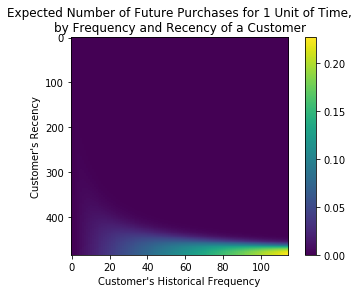

In [18]:
#heatmap plot for frequency to recency and expected number of future purchase
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

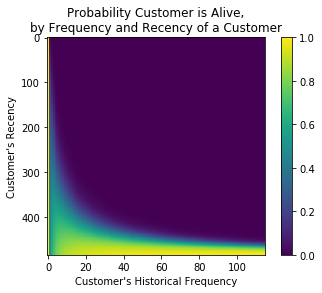

In [20]:
#heatmap plot for frequency to recency and probability if the customer is still "alive"
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

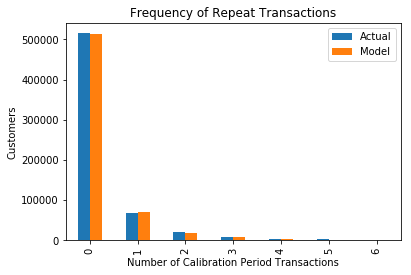

In [22]:
#assess how good the model fits; do actual and model data line up
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [19]:
#predict data for 365 days
t = 365
data['predicted_purchases_oneyear'] = bgf.predict(t,
                                          data['frequency'],
                                          data['recency'],
                                          data['T'])

In [20]:
#predict alive probability
data["status_alive"] = bgf.conditional_probability_alive(data['frequency'],
                                                         data['recency'],
                                                         data['T'])

In [22]:
data.head()

,frequency,recency,T,monetary_value,predicted_purchases_oneyear,status_alive
user_id,,,,,,
1,1.0,19.0,235.0,79.80,0.105631,0.099336
2,0.0,0.0,454.0,0.00,0.045886,1.000000
3,0.0,0.0,339.0,0.00,0.058171,1.000000
4,0.0,0.0,42.0,0.00,0.214214,1.000000
5,1.0,21.0,206.0,26.88,0.137319,0.118424


In [23]:
data.sort_values(by='predicted_purchases_oneyear').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases_oneyear,status_alive
user_id,,,,,,
459525,30.0,183.0,183.0,62.919000,26.994853,0.959764
493780,42.0,291.0,299.0,68.729762,27.334570,0.917915
345189,62.0,469.0,482.0,87.711935,28.986989,0.904029
9006,42.0,257.0,261.0,64.823095,30.572626,0.947254
483366,114.0,472.0,473.0,53.251053,58.706208,0.986160


<a id='2.3'></a>

### 2.3 Model 2 (CLV)

In [24]:
#check how correlated monetary value and frequency are
#to use the model we would want a value close to 0
data[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.478459
frequency,0.478459,1.000000


The correlations are not in fact close to 0, though this might have something to do with the given dataset. I will still run the model, altough expect slightly less important results.

Note that customers who have only one purchase get a status prediction of one hence to the model. So we have to ignore values of one in further use of this.

In [25]:
#as the method that is beeing used below requires monetary values greater than zero
#a arbitrarily small enough amount will be added to the zeroes 
def addfk(number):
    return number + 0.01 if number == 0 else number

In [26]:
#build and fit model to get clv
from lifetimes import GammaGammaFitter
data["monetary_value_plchldr"] = data["monetary_value"].apply(addfk)
returning_customers_summary = data[data['frequency'] > 0]
 
ggf = GammaGammaFitter(penalizer_coef = 0)

ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value_plchldr'])


<lifetimes.GammaGammaFitter: fitted with 107459 subjects, p: 3.04, q: 4.13, v: 103.84>

In [27]:
#print the average predicted profit and average profit
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(data['frequency'],
                                            data['monetary_value']).mean(),
    data[data['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 100.53799628412952, Average profit: 99.07519743585334


In [28]:
#expected average profit by user
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))

user_id
1      90.391532
2     100.658648
3     100.658648
4     100.658648
5      64.343068
6     100.658648
7     100.658648
8     100.658648
9     100.658648
10    100.658648
dtype: float64


In [29]:
transaction_spend = ggf.conditional_expected_average_profit(data['frequency'],
                                                            data['monetary_value']).mean()

In [30]:
df_pred_clv_1 = df_pred_clv_1.join(data["predicted_purchases_oneyear"], on = "user_id", how = "left")

In [31]:
df_pred_clv_1["clv"] = df_pred_clv_1.apply(lambda x: x["predicted_purchases_oneyear"] * transaction_spend, axis = 1)

In [32]:
df_pred_clv_1["predicted_purchases_oneyear"] = df_pred_clv_1["predicted_purchases_oneyear"].round(2)

In [33]:
df_pred_clv_1["clv"] = df_pred_clv_1["clv"].round(2)

In [35]:
df_pred_clv_1.head(10)

,user_id,revenue,women_article,men_article,kids_article,homeandliving_article,avg_shop_cart,total_purchases,avg_cart_itemcount,monday,times_bought_monday,tuesday,times_bought_tuesday,wednesday,times_bought_wednesday,thursday,times_bought_thursday,friday,times_bought_friday,saturday,times_bought_saturday,sunday,times_bought_sunday,user_type,country,region,city,device_category,device_browser,device_os,country_slim,cluster,recency,frequency,score,value_segment,predicted_purchases_oneyear,clv
0,1,147.01,6,1,0,0,73.505,2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,first,Germany,Lower Saxony,Varel,desktop,Firefox,Windows,Germany,0,216,2,1,low,0.11,10.62
1,2,208.34,8,0,0,0,208.340,1,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,first,Germany,Mecklenburg-Vorpommern,Stralsund,desktop,Internet Explorer,Windows,Germany,1,454,1,1,low,0.05,4.61
2,3,84.11,0,1,0,0,84.110,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Lower Saxony,Buchholz in der Nordheide,tablet,Safari,iOS,Germany,0,339,1,0,low,0.06,5.85
3,4,62.32,1,4,0,0,62.320,1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Berlin,Berlin,desktop,Chrome,Windows,Germany,0,42,1,2,low,0.21,21.54
4,5,89.89,0,0,4,0,44.945,2,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Schleswig-Holstein,Neumunster,tablet,Safari,iOS,Germany,0,185,2,1,low,0.14,13.81
5,6,25.20,1,0,0,0,25.200,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,North Rhine-Westphalia,Meinerzhagen,mobile,Chrome,Android,Germany,0,71,1,2,low,0.17,16.68
6,7,117.63,2,0,0,0,117.630,1,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Bavaria,Munich,mobile,Samsung Internet,Android,Germany,0,169,1,2,low,0.10,9.80
7,8,22.98,0,1,0,0,22.980,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,North Rhine-Westphalia,Bochum,mobile,Chrome,Android,Germany,0,63,1,2,low,0.18,17.75
8,9,39.45,5,0,0,0,39.450,1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Berlin,Berlin,mobile,Safari,iOS,Germany,0,231,1,1,low,0.08,7.85
9,10,142.11,1,10,0,0,142.110,1,11.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,North Rhine-Westphalia,Bergkamen,desktop,Firefox,Windows,Germany,1,337,1,0,low,0.06,5.88


In [36]:
#predict clv with DCF method
print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    data['frequency'],
    data['recency'],
    data['T'],
    data['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

user_id
1      8.931852
2      4.295077
3      5.451592
4     20.309384
5      8.272815
6     15.677185
7      9.169833
8     16.703109
9      7.326512
10     5.477366
Name: clv, dtype: float64


In [37]:
df_pred_clv_2 = df_pred_clv_2.join(data["predicted_purchases_oneyear"], on = "user_id", how = "left")

In [38]:
#save the above in the second dataframe
df_pred_clv_2 = df_pred_clv_2.join(ggf.customer_lifetime_value(bgf,
                                                               data['frequency'],
                                                               data['recency'],
                                                               data['T'],
                                                               data['monetary_value'],
                                                               time=12,
                                                               discount_rate=0.01 ),
                                   on = "user_id", how = "left")

In [39]:
df_pred_clv_2["predicted_purchases_oneyear"] = df_pred_clv_2["predicted_purchases_oneyear"].round(2)
df_pred_clv_2["clv"] = df_pred_clv_2["clv"].round(2)

In [40]:
df_pred_clv_2.head()

,user_id,revenue,women_article,men_article,kids_article,homeandliving_article,avg_shop_cart,total_purchases,avg_cart_itemcount,monday,times_bought_monday,tuesday,times_bought_tuesday,wednesday,times_bought_wednesday,thursday,times_bought_thursday,friday,times_bought_friday,saturday,times_bought_saturday,sunday,times_bought_sunday,user_type,country,region,city,device_category,device_browser,device_os,country_slim,cluster,recency,frequency,score,value_segment,predicted_purchases_oneyear,clv
0,1,147.01,6,1,0,0,73.505,2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,first,Germany,Lower Saxony,Varel,desktop,Firefox,Windows,Germany,0,216,2,1,low,0.11,8.93
1,2,208.34,8,0,0,0,208.340,1,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,first,Germany,Mecklenburg-Vorpommern,Stralsund,desktop,Internet Explorer,Windows,Germany,1,454,1,1,low,0.05,4.30
2,3,84.11,0,1,0,0,84.110,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Lower Saxony,Buchholz in der Nordheide,tablet,Safari,iOS,Germany,0,339,1,0,low,0.06,5.45
3,4,62.32,1,4,0,0,62.320,1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Berlin,Berlin,desktop,Chrome,Windows,Germany,0,42,1,2,low,0.21,20.31
4,5,89.89,0,0,4,0,44.945,2,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Schleswig-Holstein,Neumunster,tablet,Safari,iOS,Germany,0,185,2,1,low,0.14,8.27


### Plots

In [41]:
clv_pm = df_pred_clv_1["clv"]
print(clv_pm.mean())
print(clv_pm.median())

18.283340801809132
8.56


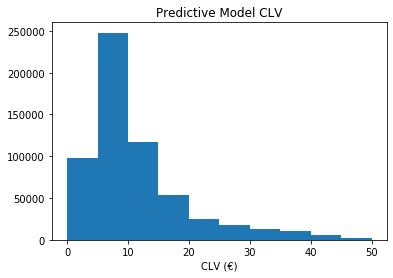

In [42]:
plt.hist(clv_pm, range = (0,50))
plt.title("Predictive Model CLV")
plt.xlabel("CLV (€)")
plt.show()

In [43]:
clv_pm = df_pred_clv_2["clv"]
print(clv_pm.mean())
print(clv_pm.median())

17.253528011602636
7.94


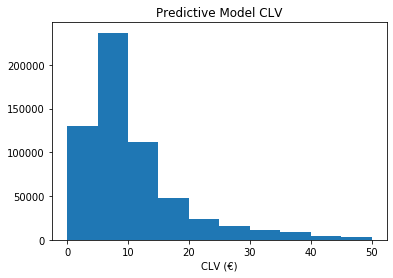

In [44]:
plt.hist(clv_pm, range = (0,50))
plt.title("Predictive Model CLV")
plt.xlabel("CLV (€)")
plt.show()

In [45]:
clv_pm = df_constant_ltv["clv"]
print(clv_pm.mean())
print(clv_pm.median())

2052.673773989467
587.54


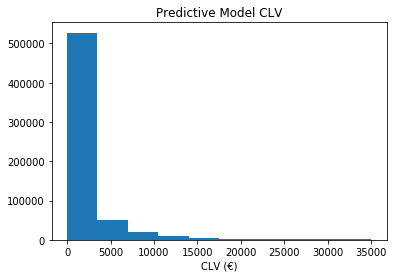

In [46]:
plt.hist(clv_pm, range = (0,35000))
plt.title("Predictive Model CLV")
plt.xlabel("CLV (€)")
plt.show()

### save to pickle

In [47]:
df_constant_ltv.to_pickle("Data/constant_clv.pickle")
df_pred_clv_1.to_pickle("Data/clv1.pickle")
df_pred_clv_2.to_pickle("Data/clv2u.pickle")